<a href="https://colab.research.google.com/github/SIADS697-NFT-Rec/siads697-analytics/blob/main/nftWallet_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Notebook Setup

In [1]:
import warnings
warnings.filterwarnings(action='once')
try:
  import requests
  import pymysql
  import sqlalchemy
  from google.cloud.sql.connector import connector
  from getpass import getpass
  from flask import g, current_app
  import tqdm
  import pyLDAvis.gensim_models
except:
  ! python -m pip install pymysql
  ! python -m pip install cloud-sql-python-connector[pg8000]
  ! python -m pip install urllib3
  ! python -m pip install getpass
  ! python -m pip install flask
  ! python -m pip install tqdm
  ! python -m pip install pyLDAvis

import os
import pandas as pd
import json
import urllib.request
import requests
import pymysql
import sqlalchemy
from google.cloud.sql.connector import connector
import time
import numpy as np
import collections
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import altair as alt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import cdist
from scipy import stats
import psycopg2
from psycopg2 import extras, pool
import tqdm
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from datetime import datetime
from gensim.test.utils import common_corpus, common_dictionary
from gensim import models
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
import pyLDAvis.gensim_models


     |████████████████████████████████| 43 kB 1.2 MB/s 
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 1.1 MB 10.0 MB/s 
     |████████████████████████████████| 3.6 MB 35.0 MB/s 
     |████████████████████████████████| 105 kB 45.1 MB/s 
     |████████████████████████████████| 271 kB 45.9 MB/s 
     |████████████████████████████████| 144 kB 68.6 MB/s 
     |████████████████████████████████| 94 kB 2.5 MB/s 
ERROR: Could not find a version that satisfies the requirement getpass (from versions: none)
ERROR: No matching distribution found for getpass
     |████████████████████████████████| 1.7 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=d8d96b3229d3003a5058374900b45fc93d328a4991a30275b74b1c9c314f4d4b
  Stored in di

/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header

In [2]:
drive.mount('/content/drive')
os.chdir('drive')
os.chdir('MyDrive')
os.chdir('projects')

Mounted at /content/drive


### DB Connector's and DB Data Load
- used for build, hashed-out for reproduceability (CSV data files)

In [3]:
# load .json credentials for Google service --- upload .json from downloads local folder to colab instance
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "opensea-333804-f005233a666e.json"

# # create connection to Mike's GCP PG database
# def getconn() -> pymysql.connections.Connection:
#   conn: pymysql.connections.Connection = connector.connect("opensea-333804:us-west1:opensea","pg8000",user="postgres",password="Thor2020!",db="postgres")
#   return conn

# pool = sqlalchemy.create_engine("postgresql+pg8000://",creator=getconn)

In [4]:
# create connection to Sahil's AZ PG database
connection_pool = psycopg2.pool.SimpleConnectionPool(1, 20, user="nftrecadmin",
                                            password="An*L61&bIf%NAdRY2Ij^ph7#F4SyIg1R",
                                            host="nft-rec-697.postgres.database.azure.com",
                                            port="5432",
                                            database="siads697")
def add_connection_to_pool(conn):
    try:
        connection_pool.putconn(conn)
    except:
        print("Had issue putting conn back")
def get_db_connection():
    return connection_pool.getconn()

1. NFT Event Data Load (Postgres DB)
  - *used for generating a list of wallet_addresses to build and test recommender system*

In [5]:
# # load data from postgres tables into dataframe
# df = pd.DataFrame()
# for table_name in ['os_data_event_rb','os_data_event']:
#   data_SQL = "SELECT approved_account,asset_bundle,auction_type,bid_amount,collection_slug,contract_address,created_date,custom_event_name,dev_fee_payment_event,dev_seller_fee_basis_points,duration,ending_price,event_type,id,is_private,owner_account,quantity,seller,starting_price,to_account,total_price,transaction,winner_account,listing_time,asset_id,asset_num_sales,asset_background_color,asset_image_url,asset_image_preview_url,asset_image_thumbnail_url,asset_image_original_url,asset_animation_url,asset_animation_original_url,asset_name,asset_description,asset_external_link,asset_asset_contract_address,asset_asset_contract_asset_contract_type,asset_asset_contract_created_date,asset_asset_contract_name,asset_asset_contract_nft_version,asset_asset_contract_opensea_version,asset_asset_contract_owner,asset_asset_contract_schema_name,asset_asset_contract_symbol,asset_asset_contract_total_supply,asset_asset_contract_description,asset_asset_contract_external_link,asset_asset_contract_image_url,asset_asset_contract_default_to_fiat,asset_asset_contract_dev_buyer_fee_basis_points,asset_asset_contract_dev_seller_fee_basis_points,asset_asset_contract_only_proxied_transfers,asset_asset_contract_opensea_buyer_fee_basis_points,asset_asset_contract_opensea_seller_fee_basis_points,asset_asset_contract_buyer_fee_basis_points,asset_asset_contract_seller_fee_basis_points,asset_asset_contract_payout_address,asset_permalink,asset_collection_banner_image_url,asset_collection_chat_url,asset_collection_created_date,asset_collection_default_to_fiat,asset_collection_description,asset_collection_dev_buyer_fee_basis_points,asset_collection_dev_seller_fee_basis_points,asset_collection_discord_url,asset_collection_display_data_card_display_style,asset_collection_external_url,asset_collection_featured,asset_collection_featured_image_url,asset_collection_hidden,asset_collection_safelist_request_status,asset_collection_image_url,asset_collection_is_subject_to_whitelist,asset_collection_large_image_url,asset_collection_medium_username,asset_collection_name,asset_collection_only_proxied_transfers,asset_collection_opensea_buyer_fee_basis_points,asset_collection_opensea_seller_fee_basis_points,asset_collection_payout_address,asset_collection_require_email,asset_collection_short_description,asset_collection_slug,asset_collection_telegram_url,asset_collection_twitter_username,asset_collection_instagram_username,asset_collection_wiki_url,asset_decimals,asset_token_metadata,asset_owner_user_username,asset_owner_profile_img_url,asset_owner_address,asset_owner_config,asset_token_id,from_account_user_username,from_account_profile_img_url,from_account_address,from_account_config,payment_token_id,payment_token_symbol,payment_token_address,payment_token_image_url,payment_token_name,payment_token_decimals,payment_token_eth_price,payment_token_usd_price FROM {}".format(table_name)
#   data = []
#   with pool.connect() as db_conn:
#     # get  data from table
#     data_payload = db_conn.execute('{}'.format(data_SQL)).fetchall()
#     for row in data_payload:
#       data.append(row)

#   col_names = ['approved_account','asset_bundle','auction_type','bid_amount','collection_slug','contract_address','created_date','custom_event_name','dev_fee_payment_event','dev_seller_fee_basis_points','duration','ending_price','event_type','id','is_private','owner_account','quantity','seller','starting_price','to_account','total_price','transaction','winner_account','listing_time','asset_id','asset_num_sales','asset_background_color','asset_image_url','asset_image_preview_url','asset_image_thumbnail_url','asset_image_original_url','asset_animation_url','asset_animation_original_url','asset_name','asset_description','asset_external_link','asset_asset_contract_address','asset_asset_contract_asset_contract_type','asset_asset_contract_created_date','asset_asset_contract_name','asset_asset_contract_nft_version','asset_asset_contract_opensea_version','asset_asset_contract_owner','asset_asset_contract_schema_name','asset_asset_contract_symbol','asset_asset_contract_total_supply','asset_asset_contract_description','asset_asset_contract_external_link','asset_asset_contract_image_url','asset_asset_contract_default_to_fiat','asset_asset_contract_dev_buyer_fee_basis_points','asset_asset_contract_dev_seller_fee_basis_points','asset_asset_contract_only_proxied_transfers','asset_asset_contract_opensea_buyer_fee_basis_points','asset_asset_contract_opensea_seller_fee_basis_points','asset_asset_contract_buyer_fee_basis_points','asset_asset_contract_seller_fee_basis_points','asset_asset_contract_payout_address','asset_permalink','asset_collection_banner_image_url','asset_collection_chat_url','asset_collection_created_date','asset_collection_default_to_fiat','asset_collection_description','asset_collection_dev_buyer_fee_basis_points','asset_collection_dev_seller_fee_basis_points','asset_collection_discord_url','asset_collection_display_data_card_display_style','asset_collection_external_url','asset_collection_featured','asset_collection_featured_image_url','asset_collection_hidden','asset_collection_safelist_request_status','asset_collection_image_url','asset_collection_is_subject_to_whitelist','asset_collection_large_image_url','asset_collection_medium_username','asset_collection_name','asset_collection_only_proxied_transfers','asset_collection_opensea_buyer_fee_basis_points','asset_collection_opensea_seller_fee_basis_points','asset_collection_payout_address','asset_collection_require_email','asset_collection_short_description','asset_collection_slug','asset_collection_telegram_url','asset_collection_twitter_username','asset_collection_instagram_username','asset_collection_wiki_url','asset_decimals','asset_token_metadata','asset_owner_user_username','asset_owner_profile_img_url','asset_owner_address','asset_owner_config','asset_token_id','from_account_user_username','from_account_profile_img_url','from_account_address','from_account_config','payment_token_id','payment_token_symbol','payment_token_address','payment_token_image_url','payment_token_name','payment_token_decimals','payment_token_eth_price','payment_token_usd_price']
#   df_rb = pd.DataFrame(data=data, columns = col_names)
#   df = pd.concat([df,df_rb])
#   time.sleep(30)
# df.shape

2. NFT Wallet Data Load (Postgres DB)
  - *used to build and test NFT recommender system in DEV*

In [6]:
# load wallet data from PG database
# table_name = 'os_wallet_data'
# data_SQL = "SELECT * FROM {} WHERE event_type in ('successful','created')".format(table_name)
# data = []
# with pool.connect() as db_conn:
#   # get  data from table
#   data_payload = db_conn.execute('{}'.format(data_SQL)).fetchall()
#   for row in data_payload:
#     data.append(row)
# col_names = ['asset_id', 'asset_num_sales', 'asset_image_url', 'asset_image_preview_url', 'asset_image_thumbnail_url', 'asset_image_original_url', 'asset_name', 'asset_description', 'asset_asset_contract_address', 'asset_asset_contract_asset_contract_type', 'asset_asset_contract_created_date', 'asset_asset_contract_name', 'asset_asset_contract_nft_version', 'asset_asset_contract_owner', 'asset_asset_contract_schema_name', 'asset_asset_contract_symbol', 'asset_asset_contract_total_supply', 'asset_asset_contract_description', 'asset_asset_contract_external_link', 'asset_asset_contract_image_url', 'asset_asset_contract_default_to_fiat', 'asset_asset_contract_dev_buyer_fee_basis_points', 'asset_asset_contract_dev_seller_fee_basis_points', 'asset_asset_contract_only_proxied_transfers', 'asset_asset_contract_opensea_buyer_fee_basis_points', 'asset_asset_contract_opensea_seller_fee_basis_points', 'asset_asset_contract_buyer_fee_basis_points', 'asset_asset_contract_seller_fee_basis_points', 'asset_asset_contract_payout_address', 'asset_permalink', 'asset_collection_banner_image_url', 'asset_collection_created_date', 'asset_collection_default_to_fiat', 'asset_collection_description', 'asset_collection_dev_buyer_fee_basis_points', 'asset_collection_dev_seller_fee_basis_points', 'asset_collection_discord_url', 'asset_collection_display_data_card_display_style', 'asset_collection_external_url', 'asset_collection_featured', 'asset_collection_featured_image_url', 'asset_collection_hidden', 'asset_collection_safelist_request_status', 'asset_collection_image_url', 'asset_collection_is_subject_to_whitelist', 'asset_collection_large_image_url', 'asset_collection_name', 'asset_collection_only_proxied_transfers', 'asset_collection_opensea_buyer_fee_basis_points', 'asset_collection_opensea_seller_fee_basis_points', 'asset_collection_payout_address', 'asset_collection_require_email', 'asset_collection_slug', 'asset_collection_twitter_username', 'asset_collection_instagram_username', 'asset_collection_is_nsfw', 'asset_decimals', 'asset_token_metadata', 'asset_is_nsfw', 'asset_owner_user_username', 'asset_owner_profile_img_url', 'asset_owner_address', 'asset_token_id', 'collection_slug', 'contract_address', 'created_date', 'event_type', 'from_account_user_username', 'from_account_profile_img_url', 'from_account_address', 'id', 'is_private', 'quantity', 'to_account_user_username', 'to_account_profile_img_url', 'to_account_address', 'transaction_block_hash', 'transaction_block_number', 'transaction_from_account_user_username', 'transaction_from_account_profile_img_url', 'transaction_from_account_address', 'transaction_id', 'transaction_timestamp', 'transaction_to_account_profile_img_url', 'transaction_to_account_address', 'transaction_transaction_hash', 'transaction_transaction_index', 'listing_time', 'payment_token_id', 'payment_token_symbol', 'payment_token_address', 'payment_token_image_url', 'payment_token_name', 'payment_token_decimals', 'payment_token_eth_price', 'payment_token_usd_price', 'seller_user_username', 'seller_profile_img_url', 'seller_address', 'wallet_address', 'timestmp']
# w_df = pd.DataFrame(data=data, columns = col_names)

3. NFT Trait Data Load (Postgres DB)
  - *used to build and test NFT recommender system in DEV*

In [7]:
# function for getting trait data from Sahil's AZ DB
def get_asset_data_for_tokens():
    """
    Get drilled down data for given asset token IDs
    :param asset_tokens: asset token IDs
    :return: asset data needed by the frontend
    """
    conn = get_db_connection()
    cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)
    cur.execute("""
        WITH asset_records AS (SELECT * from asset_catalog_v4)
        SELECT *
        FROM asset_records p
        LEFT JOIN asset_traits_v4 c
        USING (asset_id)
        """)
    trait_rows = cur.fetchall()

    return pd.DataFrame(trait_rows)
trait_df = get_asset_data_for_tokens()

### CSV Data Load
- replace DB conn's with CSV file

In [8]:
# NFT wallet data set load
w_df = pd.read_csv('gotham/data/nft_wallet_data.csv',error_bad_lines=True)
print('total records in dataset: {}'.format(len(w_df)))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (73,74,75,76,78,87,89) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


total records in dataset: 563665


In [9]:
event_df = pd.read_csv('gotham/data/nft_event_data.csv')
# event_df.shape
# list(event_df.columns)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (50,53,63,70,72,75,79,83,100) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### NFT Wallet Data Processing & Feature Engineering
- used to build model for classifying wallet type and generating intuition on right number of wallet owner types

In [15]:
# rebuild asset_num_sales from prior str cleaning resulting in decimal replacement with whitespace
w_df['asset_num_sales'].fillna('0', inplace = True)
w_df['asset_num_sales'] = w_df['asset_num_sales'].str.replace('nan','0').apply(lambda x: int(str(x).split(' ')[0]))
# rebuild payment_token_usd_price from prior str cleaning resulting in decimal replacement with whitespace
w_df['payment_token_usd_price'].fillna('0', inplace = True)
w_df['payment_token_usd_price'] = w_df['payment_token_usd_price'].str.replace('None','0').str.replace('nan','0').apply(lambda x: int(str(x).split(' ')[0]))

w_df['token_id_contract_address'] = w_df['asset_token_id'] + w_df['asset_asset_contract_address'] 
print('unique NFTs + contracts in the dataset: {}'.format(w_df['token_id_contract_address'].nunique()))
print('unique wallets in the dataset: {}'.format(w_df['wallet_address'].nunique()))
print('total records in dataset: {}'.format(len(w_df)))

unique NFTs + contracts in the dataset: 205344
unique wallets in the dataset: 3214
total records in dataset: 563665


In [16]:
# randomly sample an NFT wallet
pd.set_option('display.max_columns',250)
w_df[w_df.wallet_address == w_df.wallet_address.sample().values[0]].head(1)

Unnamed: 0 asset_id  asset_num_sales asset_image_url  \
322672      322672      NaN                0             NaN   

       asset_image_preview_url asset_image_thumbnail_url  \
322672                     NaN                       NaN   

       asset_image_original_url asset_name asset_description  \
322672                      NaN        NaN               NaN   

       asset_asset_contract_address asset_asset_contract_asset_contract_type  \
322672                          NaN                                      NaN   

       asset_asset_contract_created_date asset_asset_contract_name  \
322672                               NaN                       NaN   

       asset_asset_contract_nft_version asset_asset_contract_owner  \
322672                              NaN                        NaN   

       asset_asset_contract_schema_name asset_asset_contract_symbol  \
322672                              NaN                         NaN   

       asset_asset_contract_total_supply asset_asset_contract_description  \
322672                               NaN                              NaN   

       asset_asset_contract_external_link asset_asset_contract_image_url  \
322672                                NaN                            NaN   

       asset_asset_contract_default_to_fiat  \
322672                                  NaN   

       asset_asset_contract_dev_buyer_fee_basis_points  \
322672                                             NaN   

       asset_asset_contract_dev_seller_fee_basis_points  \
322672                                              NaN   

       asset_asset_contract_only_proxied_transfers  \
322672                                         NaN   

       asset_asset_contract_opensea_buyer_fee_basis_points  \
322672                                                NaN    

       asset_asset_contract_opensea_seller_fee_basis_points  \
322672                                                NaN     

       asset_asset_contract_buyer_fee_basis_points  \
322672                                         NaN   

       asset_asset_contract_seller_fee_basis_points  \
322672                                          NaN   

       asset_asset_contract_payout_address asset_permalink  \
322672                                 NaN             NaN   

       asset_collection_banner_image_url asset_collection_created_date  \
322672                               NaN                           NaN   

       asset_collection_default_to_fiat asset_collection_description  \
322672                              NaN                          NaN   

        asset_collection_dev_buyer_fee_basis_points  \
322672                                          NaN   

        asset_collection_dev_seller_fee_basis_points  \
322672                                           NaN   

       asset_collection_discord_url  \
322672                          NaN   

       asset_collection_display_data_card_display_style  \
322672                                              NaN   

       asset_collection_external_url asset_collection_featured  \
322672                           NaN                       NaN   

       asset_collection_featured_image_url asset_collection_hidden  \
322672                                 NaN                     NaN   

       asset_collection_safelist_request_status asset_collection_image_url  \
322672                                      NaN                        NaN   

       asset_collection_is_subject_to_whitelist  \
322672                                      NaN   

       asset_collection_large_image_url asset_collection_name  \
322672                              NaN                   NaN   

       asset_collection_only_proxied_transfers  \
322672                                     NaN   

        asset_collection_opensea_buyer_fee_basis_points  \
322672                                              NaN   

        asset_collection_opensea_seller_fee_basis_points  \
322672                               

Wallet feature engineering: we hypothesize some combination of these features might enable wallet profiling / clustering to drive a more precise recommender logic based on wallet characterization
- Total unique NFTS held
- Total NFTs purchased, and % of total held
- Total NFTs minted, and % of total held
- Total NFTs sold, and % of total held 
- Count of unique collections held
- Count of the max collection holding
- Count of min collection holding
- Count of mean collection holdering
- Average of NFT volume for NFTs in the wallet
- Median of NFT volume for NFTs in the wallet
- Min of NFT volume for NFTs in the wallet
- Max of NFT volume for NFTs in the wallet

In [21]:
# feature creation / wallet data aggregation (per the above)
total_nft_held = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_token_id'].nunique()
total_nft_transacted = w_df[w_df.event_type == 'successful'].groupby('wallet_address')['asset_token_id'].nunique()
total_nft_sale = w_df[(w_df.seller_address == w_df.wallet_address)].groupby('wallet_address')['asset_token_id'].nunique()
unique_collections_held = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['collection_slug'].nunique()
max_collection_count = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby(['wallet_address','collection_slug']).agg({'asset_id':lambda x: len(np.unique(x))}).groupby('wallet_address').agg({'asset_id':np.max}).reset_index().set_index('wallet_address')
min_collection_count = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby(['wallet_address','collection_slug']).agg({'asset_id':lambda x: len(np.unique(x))}).groupby('wallet_address').agg({'asset_id':np.min}).reset_index().set_index('wallet_address')
avg_collection_count = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby(['wallet_address','collection_slug']).agg({'asset_id':lambda x: len(np.unique(x))}).groupby('wallet_address').agg({'asset_id':np.mean}).reset_index().set_index('wallet_address')
avg_nft_vol = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_num_sales'].mean()
median_nft_vol = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_num_sales'].median()
min_nft_vol = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_num_sales'].min()
max_nft_vol = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_num_sales'].max()
avg_eth_usd_price = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby(['wallet_address']).agg({'payment_token_usd_price':np.mean})

In [22]:
# feature dataframe representation
features = {
'total_nft_held':total_nft_held,'total_nft_transacted':total_nft_transacted,
 'total_nft_sale':total_nft_sale,'unique_collections_held':unique_collections_held,
 'max_collection_count':max_collection_count,'min_collection_count':min_collection_count,'avg_collection_count':avg_collection_count,
 'avg_nft_vol':avg_nft_vol,'median_nft_vol':median_nft_vol,'min_nft_vol':min_nft_vol,'max_nft_vol':max_nft_vol,'avg_eth_usd_price':avg_eth_usd_price
}
feature_df = pd.DataFrame(columns=['wallet_address'], data = total_nft_held.index).set_index('wallet_address')

for k,v in features.items():
  try:
    features[k].name = features[k].name.replace(features[k].name,'{}'.format(k))
  except:
    features[k].rename(columns={str(features[k].columns[0]):'{}'.format(k)}, inplace=True)
  feature_df = pd.merge(feature_df,features[k], how='left',left_index=True,right_index=True)

feature_df['total_nft_sale'] = feature_df['total_nft_sale'].fillna(0)
feature_df['nft_churn'] = feature_df['total_nft_transacted'] / feature_df['total_nft_held']
feature_df['nft_sale_pct_transacted'] = feature_df['total_nft_sale'] / feature_df['total_nft_transacted']
feature_df['colletion_spread'] = feature_df['max_collection_count'] - feature_df['min_collection_count']

In [23]:
# Remove high transaction volume wallets as these are indicative of robotic / systemic transactions and therefore unlikely to be good candidates for a recommender system; 
# similar for wallets containing > n number of NFTs

n_transacted = 500
n_held = 500
n_churn = 100 # ratio of transacted / held
feature_df = feature_df[(feature_df['total_nft_transacted'] < n_transacted)&(feature_df['total_nft_held'] < n_held)&(feature_df['nft_churn'] < n_churn)]

### NFT Wallet Exploratory Data Analysis
- Visualize the wallet NFT distributions of the count of NFT transactions, count of NFTs held and unique NFT collections held for insights into global wallet composition
- Analyze relationships between variables to identify relevant characteristics of wallet holders. For example, do wallets with high transaction volumes tend to focus on a particular collection or are they broad-based / diversified?  

In [15]:
feature_df.describe()

total_nft_held  total_nft_transacted  total_nft_sale  \
count     2813.000000           2813.000000     2813.000000   
mean        19.469961             43.030217       36.806257   
std         29.270096             64.596038       81.923574   
min          1.000000              0.000000        0.000000   
25%          3.000000              6.000000        3.000000   
50%          9.000000             18.000000       12.000000   
75%         22.000000             51.000000       39.000000   
max        263.000000            493.000000     2505.000000   

       unique_collections_held  max_collection_count  min_collection_count  \
count              2813.000000           2813.000000           2813.000000   
mean                  9.037327              5.544970              1.460718   
std                  11.293402              9.468627              4.623480   
min                   1.000000              1.000000              1.000000   
25%                   2.000000              2.000000              1.000000   
50%                   5.000000              3.000000              1.000000   
75%                  11.000000              5.000000              1.000000   
max                 116.000000            191.000000            191.000000   

       avg_collection_count  avg_nft_vol  median_nft_vol  min_nft_vol  \
count           2813.000000  2813.000000     2813.000000  2813.000000   
mean               2.353884     1.341023        1.160683     0.528973   
std                4.893703     0.796253        0.869278     0.769458   
min                1.000000     0.000000        0.000000     0.000000   
25%                1.100000     0.896552        1.000000     0.000000   
50%                1.500000     1.268657        1.000000     0.000000   
75%                2.200000     1.750000        1.500000     1.000000   
max              191.000000     8.000000        8.000000     8.000000   

       max_nft_vol  avg_eth_usd_price    nft_churn  nft_sale_pct_transacted  \
count  2813.000000        2813.000000  2813.000000                  2813.00   
mean      3.121223        2909.710159     2.952752                      inf   
std       1.799485         345.961040     4.618099                      NaN   
min       0.000000           2.000000     0.000000                     0.00   
25%       2.000000        2603.000000     1.090909                     0.30   
50%       3.000000        2906.163265     1.733333                     0.75   
75%       4.000000        3131.928571     3.000000                     1.00   
max      13.000000        3520.000000    71.000000                      inf   

       colletion_spread  
count       2813.000000  
mean           4.084252  
std            8.437433  
min            0.000000  
25%            0.000000  
50%            1.000000  
75%            4.000000  
max          110.000000

In [53]:
stdDevs = 3
model_vars = feature_df.copy()
# add upper and lower bounds to df for histogram visualization, based on above std devs param

fields = ['total_nft_transacted','total_nft_held','unique_collections_held']
for field in fields:
  model_vars['{}_lower'.format(field)] = model_vars['{}'.format(field)] - (np.std(model_vars['{}'.format(field)]) * stdDevs)
  model_vars['{}_upper'.format(field)] = model_vars['{}'.format(field)] + (np.std(model_vars['{}'.format(field)]) * stdDevs)

base_chart = alt.Chart(model_vars)
#distribution of total_nfts_transacted with std deviations per above variable
nft_trans_bar = base_chart.mark_bar(color='#38761d').encode(alt.X("total_nft_transacted:Q", bin=alt.Bin(extent=[0, 200], step=50)), y='count()')
trans_mean = base_chart.mark_rule(color='black').encode(x=alt.X('mean(total_nft_transacted):Q',title='Total NFTs Transacted'))
trans_histogram = nft_trans_bar + trans_mean 
trans_histogram = trans_histogram.properties(width=600,height=560)

# distribution of total_nft_held with std deviations per above variable
nft_held_bar = base_chart.mark_bar(color='#38761d').encode(alt.X("total_nft_held:Q", bin=True), y='count()').interactive()
held_mean = base_chart.mark_rule(color='black').encode(x=alt.X('mean(total_nft_held):Q',title="Total NFTs Held"))
held_histogram = nft_held_bar + held_mean
held_histogram = held_histogram.properties(width=450,height=250)

# distribution of word counts with std deviations per above variable
colls_held_bar = base_chart.mark_bar(color='#38761d').encode(alt.X("unique_collections_held:Q", bin=True), y='count()').interactive()
colls_mean = base_chart.mark_rule(color='black').encode(x=alt.X('mean(unique_collections_held):Q',title="Unique Collections Held"))
colls_histogram = colls_held_bar + colls_mean
colls_histogram = colls_histogram.properties(width=450,height=250)

held_mets = alt.vconcat(held_histogram,colls_histogram)
alt.hconcat(trans_histogram,held_mets).configure_axis(
    labelFontSize=18,
    titleFontSize=18
)


alt.HConcatChart(...)

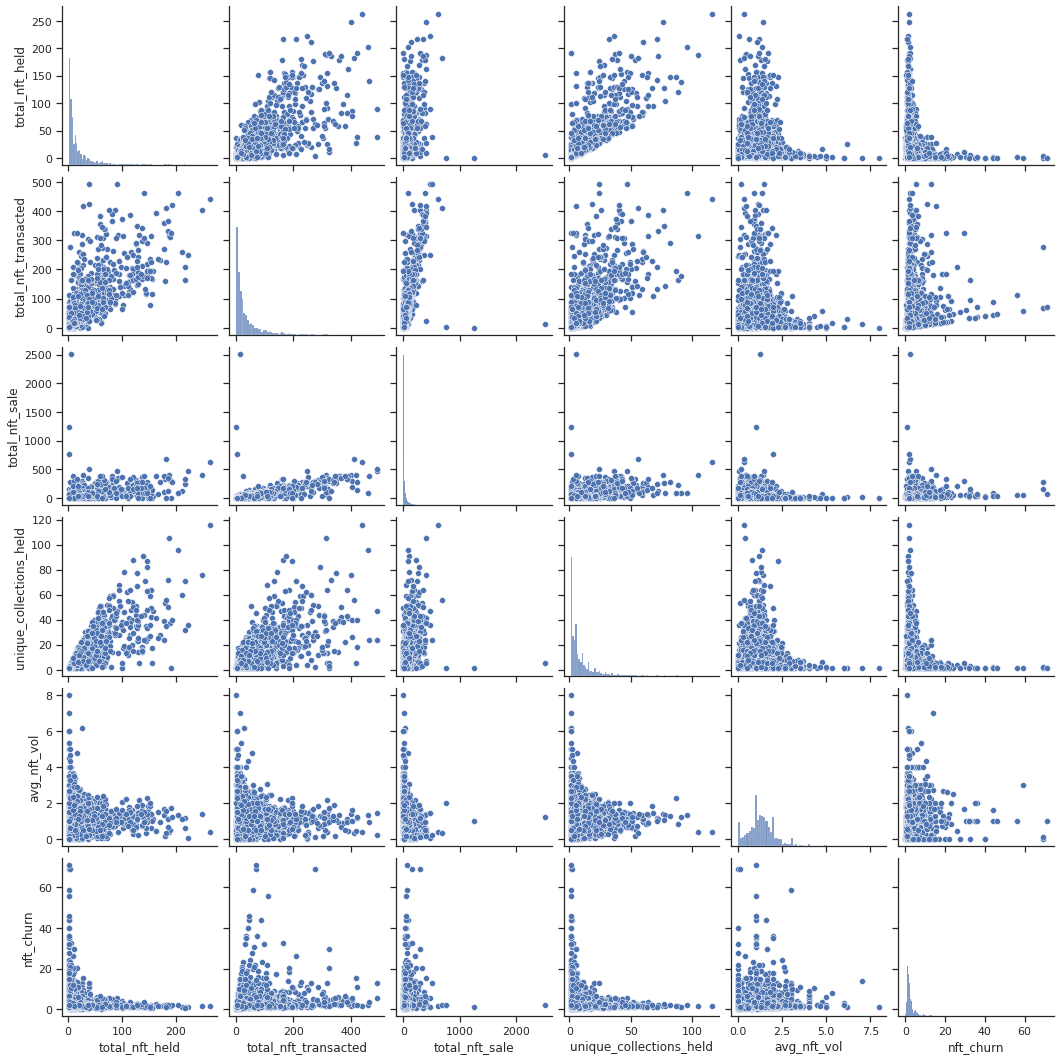

In [31]:
  # view a pair-plot / scatter plot matrix of the wallet features
sns.set_theme(style="ticks")
sns.pairplot(feature_df[['total_nft_held','total_nft_transacted','total_nft_sale','unique_collections_held','avg_nft_vol','nft_churn']])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


R2 value: 0.6624572657664476


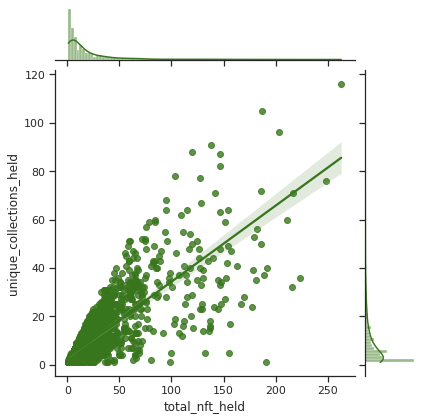

In [65]:
y = feature_df['unique_collections_held']
x = feature_df['total_nft_held']

sns.jointplot(x, y, kind="reg", color='#38761d')
print('R2 value: {}'.format(stats.pearsonr(x, y)[0] ** 2))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


R2 value: 0.11461385383438664


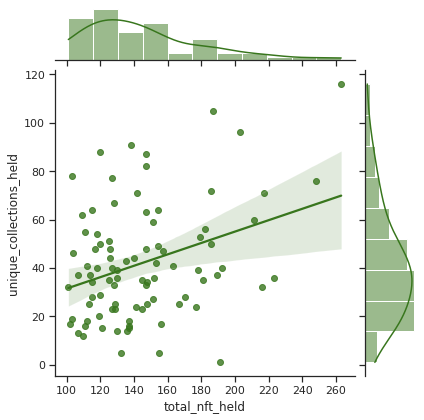

In [96]:
n = 100
y2 = feature_df[feature_df['total_nft_held']> n]['unique_collections_held']
x2 = feature_df[feature_df['total_nft_held']> n]['total_nft_held']

sns.jointplot(x2, y2, kind="reg", color='#38761d')
print('R2 value: {}'.format(stats.pearsonr(x2, y2)[0] ** 2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


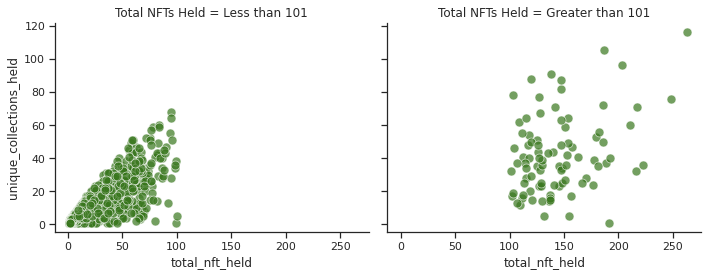

In [94]:
n = 101
scat_df = feature_df[['total_nft_held','unique_collections_held']]
scat_df['Total NFTs Held'] = np.where(scat_df['total_nft_held']<n, "Less than {}".format(n), "Greater than {}".format(n) )

g = sns.FacetGrid(scat_df, col="Total NFTs Held", height=4, aspect= 1.25)
g.map(sns.scatterplot, "total_nft_held", "unique_collections_held", alpha=.7, edgecolor="white", s=80, color='#38761d')

### NFT Wallet Clustering Model (Unsupervised) Build & Evaluation
- k-means model build
- optimal cluster evaluation
- cluster labeling analysis

In [112]:
hist_df = feature_df[['total_nft_sale','avg_nft_vol','nft_churn']]

base_chart = alt.Chart(hist_df)
# distribution of total_nft_held with std deviations per above variable
nft_held_sale = base_chart.mark_bar(color='#38761d').encode(alt.X("total_nft_sale:Q", bin=True), y='count()').properties(width=250,height=200)
avg_nft_vol = base_chart.mark_bar(color='#38761d').encode(alt.X("avg_nft_vol:Q", bin=True), y='count()').properties(width=250,height=200)
nft_churn = base_chart.mark_bar(color='#38761d').encode(alt.X("nft_churn:Q", bin=True), y='count()').properties(width=250,height=200)

held_mets = alt.hconcat(nft_held_sale,avg_nft_vol,nft_churn).configure_axis(labelFontSize=14,titleFontSize=14)

held_mets

alt.HConcatChart(...)

In [97]:
X = feature_df[['total_nft_held','total_nft_transacted','total_nft_sale','unique_collections_held','avg_nft_vol','nft_churn']]

score = [] # Calinski-Harabasz / Davies-Bouldin score -- higher is better
distortions = [] # list to hold distorition scores
inertias = [] # list to hold inertia scores
mapping1 = {}
mapping2 = {}

k_min = 2
k_max = 20

k_space = [np.int(x) for x in np.linspace(k_min, k_max, num= k_max-k_min+1)]
for k in k_space:
    # when running KMeans, set init='k-means++', max_iter=100, n_init=1
    cla = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1).fit(X)
    labels = cla.labels_
    # looking for clusterings that have a high Calinski-Harabasz index, but a low Davies-Bouldin score
    ch_score = calinski_harabasz_score(X.to_numpy(), labels)
    db_score = davies_bouldin_score(X.to_numpy(), labels)
    score.append(ch_score / db_score)
    # elbow method
    distortions.append(sum(np.min(cdist(X, cla.cluster_centers_,'euclidean'), axis=1)) / X.shape[0])
    inertias.append(cla.inertia_)
    mapping1[k] = sum(np.min(cdist(X, cla.cluster_centers_,'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = cla.inertia_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addition

In [100]:
# # visualize the classifier performance for different values of K
# fig,ax = plt.subplots(figsize=(15,9))
# ax.plot(k_space, score, color="grey", marker="o",)
# ax.set_xlabel("Cluster Size",fontsize=14)
# ax.set_ylabel("C-H / D-B Score",fontsize=14, color='grey')
# ax2=ax.twinx()
# # make a plot with different y-axis using second axis object
# ax2.plot(k_space, inertias, color="blue", marker="x")
# ax2.set_ylabel("Inertia Score (elbow method)",color="blue",fontsize=14)
# plt.xticks(k_space)
# plt.show()

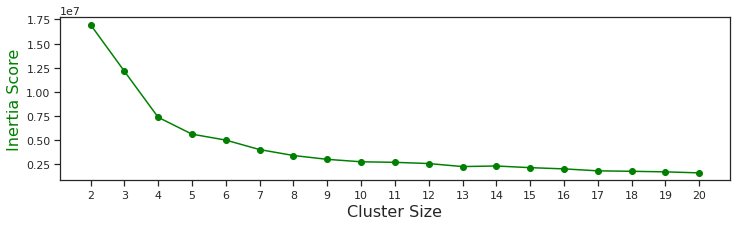

In [135]:
# visualize the classifier performance for different values of K
fig,ax = plt.subplots(figsize=(12,3))
ax.set_xlabel("Cluster Size",fontsize=16)
ax.plot(k_space, inertias, color="green", marker="o")
ax.set_ylabel("Inertia Score",color="green",fontsize=16)
plt.xticks(k_space)
plt.show()

In [102]:
# predict classes for the NFT wallets with k = best k (high C-H index, low D-B score, elbow method for inertia score)
k = 5
cla = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1).fit(X)
feature_df['class_prediction'] = list(cla.predict(X))
feature_df['class_prediction'] = feature_df['class_prediction'].astype(str)

In [103]:
feature_df.groupby('class_prediction').describe()

total_nft_held                                          \
                          count        mean        std  min   25%   50%   
class_prediction                                                          
0                        2297.0   10.434915  10.897937  1.0   3.0   7.0   
1                          89.0  100.033708  62.501173  4.0  55.0  84.0   
2                         424.0   51.625000  37.292511  1.0  25.0  42.0   
3                           2.0    1.000000   0.000000  1.0   1.0   1.0   
4                           1.0    6.000000        NaN  6.0   6.0   6.0   

                               total_nft_transacted                         \
                    75%    max                count        mean        std   
class_prediction                                                             
0                  14.0   70.0               2297.0   19.091424  18.083801   
1                 137.0  263.0                 89.0  295.629213  83.617960   
2                  66.0  191.0                424.0  119.962264  45.049104   
3                   1.0    1.0                  2.0    1.500000   0.707107   
4                   6.0    6.0                  1.0   13.000000        NaN   

                                                     total_nft_sale  \
                   min     25%    50%     75%    max          count   
class_prediction                                                      
0                  0.0    5.00   13.0   29.00   85.0         2297.0   
1                 25.0  242.00  289.0  344.00  493.0           89.0   
2                 33.0   85.75  108.0  150.00  325.0          424.0   
3                  1.0    1.25    1.5    1.75    2.0            2.0   
4                 13.0   13.00   13.0   13.00   13.0            1.0   

                                                                             \
                         mean         std     min      25%     50%      75%   
class_prediction                                                              
0                   13.733566   15.910312     0.0     2.00     8.0    20.00   
1                  286.617978  101.153181    82.0   227.00   279.0   342.00   
2                   98.978774   45.939543     0.0    70.00    91.0   127.50   
3                 1004.500000  342.946789   762.0   883.25  1004.5  1125.75   
4                 2505.000000         NaN  2505.0  2505.00  2505.0  2505.00   

                         unique_collections_held                             \
                     max                   count       mean        std  min   
class_prediction                                                              
0                   89.0                  2297.0   5.728341   5.335295  1.0   
1                  685.0                    89.0  36.797753  23.699434  2.0   
2                  225.0                   424.0  21.183962  14.376042  1.0   
3                 1247.0                     2.0   1.000000   0.000000  1.0   
4                 2505.0                     1.0   5.000000        NaN  5.0   

                                          max_collection_count             \
                   25%   50%   75%    max                count       mean   
class_prediction                                                            
0                  2.0   4.0   8.0   38.0               2297.0   3.776665   
1                 19.0  34.0  48.0  116.0                 89.0  17.876404   
2                 10.0  19.0  29.0   91.0                424.0  12.566038   
3                  1.0   1.0   1.0    1.0                  2.0   1.000000   
4                  5.0   5.0   5.0    5.0                  1.0   2.000000   

                                                           \
                        std  min  25%   50%    75%    max   
class_prediction                                            
0                  4.906816  1.0  1.0   2.0   4.00   53.0   
1                 18.403199  3.0  7.0  11.0  20.00   91.0   
2                 17.214689  1.0  

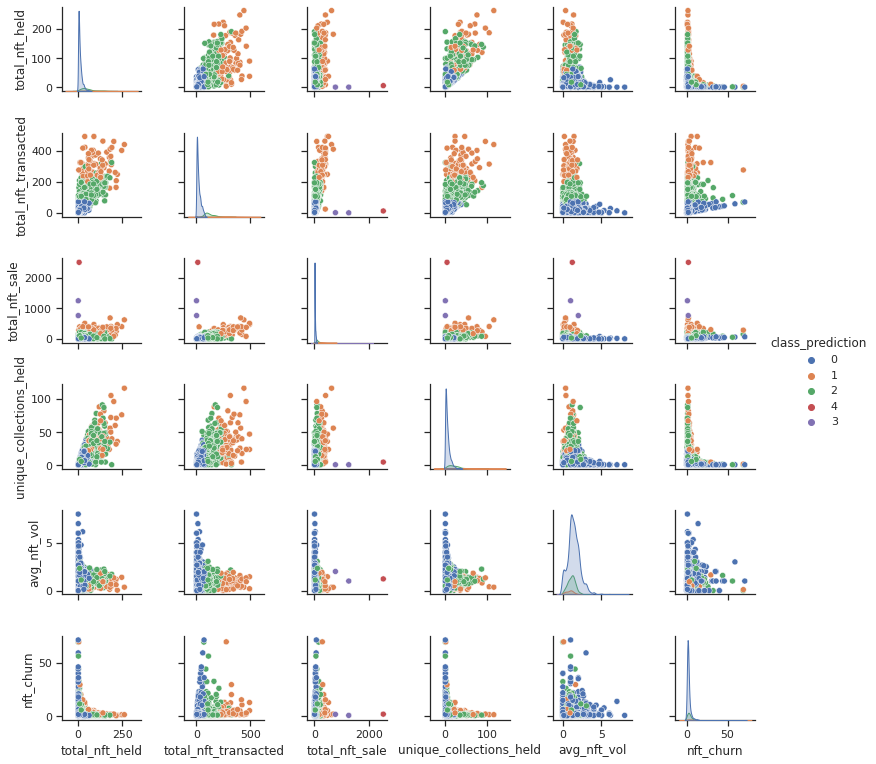

In [137]:
#sns.set_theme(style="ticks")
sns.pairplot(feature_df[['total_nft_held','total_nft_transacted','total_nft_sale','unique_collections_held','avg_nft_vol','class_prediction','nft_churn']], hue='class_prediction', height=1.8)

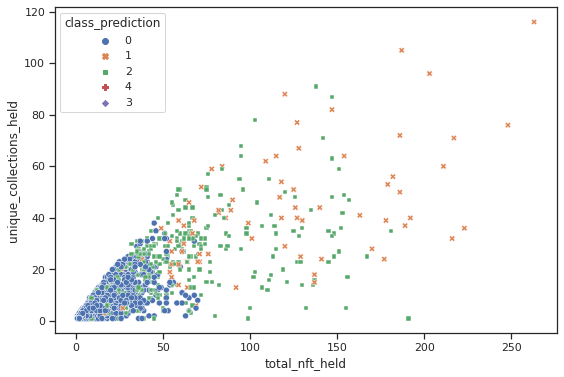

In [121]:
x = 'total_nft_held'
y = 'unique_collections_held'
fig,ax = plt.subplots(figsize=(9,6))
sns.scatterplot(data=feature_df, x=x, y=y, hue="class_prediction", style="class_prediction")


### NFT Topic Modeling (Latent Semantic Indexing / Latent Dirichlet Allocation)

NFT description text pre-processing loading into vectorizer and LSI / LDA modeling


In [12]:
def nft_text_cleaning(nft_description_list):
  # remove all non-alpha tokens (not chars) from NFT descriptions, remove stopwords (including terms "NFT and ETH")
  # import gensim stopwords corpus, add the terms "nft" and "eth" to gensim stopwords corpa as well as other low info-gain words showing up in descriptions
  # apply list comprehension to filter out stopwords per Gensims stopswords corpa
  unique_assets_filtered = [[nft_token_word for nft_token_word in nft_doc.lower().split() if (nft_token_word not in STOPWORDS.union(set(['nft', 'eth','https','s','ipfs','collection','com','www','ethereum','org','http'])) and nft_token_word.isnumeric() == False and len(nft_token_word) >3 and len(nft_token_word) < 15 )] for nft_doc in nft_description_list]
#  unique_assets_filtered = [[nft_token_word for nft_token_word in nft_doc.lower().split() if (nft_token_word not in STOPWORDS) and (nft_token_word.isnumeric() == False)] for nft_doc in nft_description_list]
  return unique_assets_filtered

def token_count_frequency(token_list):
  # create dict with token:freq_count entries for frequency count analysis
  token_freq_dict = collections.defaultdict(int)
  for nft_desc in token_list:
    for token in nft_desc:
      token_freq_dict[token] += 1
  return token_freq_dict

In [13]:
# generate a list of documents representing the set of cleaned NFT descriptions
w_df.asset_description = w_df.asset_description.astype(str)
unique_assets = w_df[w_df.asset_description!='None'].dropna(subset=['asset_description']).asset_description.unique()

cleaned_nft_descriptions = nft_text_cleaning(unique_assets)
token_freq = token_count_frequency(cleaned_nft_descriptions)

Analysis of NFT description Token Frequency

In [ ]:
token_freq_df = pd.DataFrame.from_dict(token_freq, orient='index', columns = ['token_count']).sort_values(by='token_count',ascending=False)
token_freq_df.token_count.describe()

In [ ]:
token_freq_df.head(50).plot.bar(figsize=(12,5), color='#674ea7')


In [ ]:
# apply list comprehension to filter tokens with a count above / below a defined threshold from unique_assets
min_token_cnt = 100 # remove words that appear < 10 times
max_token_cnt = 10000 # remove words that appear > 10000 times
unique_assets_filtered = [[token for token in nft_desc.split(' ') if (token_freq[token] > min_token_cnt and token_freq[token] < max_token_cnt)] for nft_desc in unique_assets]

In [17]:
gensim_dict = corpora.Dictionary(unique_assets_filtered)
corpus = [gensim_dict.doc2bow(nft_desc) for nft_desc in unique_assets_filtered]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [18]:
lsi_coherence_scores = {}
lda_coherence_scores = {}
for n_topics in list(np.linspace(5,100,20)):
  lsi_model = models.LsiModel(corpus_tfidf, id2word=gensim_dict, num_topics=n_topics)
  lda_model = models.LdaModel(corpus, id2word=gensim_dict, num_topics=n_topics)
  for model in [lsi_model,lda_model]:
    coherence_mod = CoherenceModel(model=model, corpus=corpus, coherence='c_v', texts=unique_assets_filtered)
    if model == lsi_model:
      lsi_coherence_scores["{} topics".format(n_topics)] = coherence_mod.get_coherence()  # append dict with lsi coherence score
    else:
      lda_coherence_scores["{} topics".format(n_topics)] = coherence_mod.get_coherence()  # append dict with lda coherence score

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [30]:
lsi_scores_df = pd.DataFrame.from_dict(lsi_coherence_scores, orient='index', columns=['lsi_coherence_scores'])
lda_scores_df = pd.DataFrame.from_dict(lda_coherence_scores, orient='index', columns=['lda_coherence_scores'])

In [31]:
coherence_score_df = pd.merge(lsi_scores_df, lda_scores_df, how='left', left_index=True, right_index=True)
coherence_score_df.index

Index(['5.0 topics', '10.0 topics', '15.0 topics', '20.0 topics',
       '25.0 topics', '30.0 topics', '35.0 topics', '40.0 topics',
       '45.0 topics', '50.0 topics', '55.0 topics', '60.0 topics',
       '65.0 topics', '70.0 topics', '75.0 topics', '80.0 topics',
       '85.0 topics', '90.0 topics', '95.0 topics', '100.0 topics'],
      dtype='object')

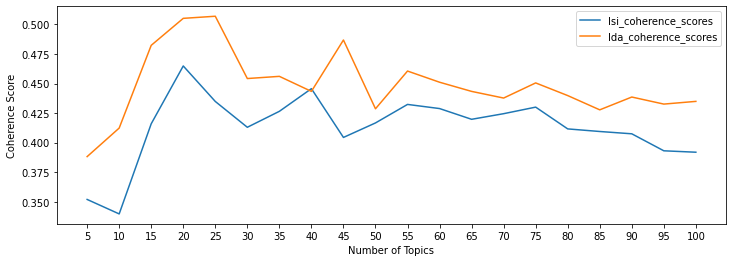

In [55]:
coherence_score_df = pd.merge(lsi_scores_df, lda_scores_df, how='left', left_index=True, right_index=True)

t = [str(s).replace('.0','') for s in [str(n).replace(' topics','') for n in coherence_score_df.index]]
s = coherence_score_df[['lsi_coherence_scores','lda_coherence_scores']]

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t, s)
plt.ylabel('Coherence Score')
plt.xlabel('Number of Topics')
plt.legend(['lsi_coherence_scores','lda_coherence_scores'])
plt.show()

In [58]:
pyLDAvis.enable_notebook()
ldamodel_highcv = models.LdaModel(corpus, id2word=gensim_dict, num_topics=25)
vis = pyLDAvis.gensim_models.prepare(ldamodel_highcv, corpus, gensim_dict)
vis

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
20    -0.068109  0.057279       1        1  8.719189
0     -0.072440  0.169726       2        1  5.582660
16     0.048364  0.098475       3        1  5.386869
23     0.203025  0.014658       4        1  5.061690
18     0.124285  0.089319       5        1  4.712126
10    -0.043221  0.094210       6        1  4.695856
11     0.220714 -0.154657       7        1  4.682514
17     0.027732  0.077469       8        1  4.674679
13     0.131250 -0.017754       9        1  4.636153
14    -0.039200  0.221663      10        1  4.574742
8     -0.005918  0.159974      11        1  4.421052
9      0.064081 -0.130972      12        1  4.378811
7      0.213029 -0.015306      13        1  4.126985
15    -0.109720  0.115092      14        1  3.770682
6     -0.089605 -0.003527      15        1  3.660321
1     -0.102485  0.034887      16        1  3.578585
4     -0.088831  0.072400      17        1  3.276213
21     0.039672 -0.065772      18        1  3.117321
19    -0.267739 -0.218324      19        1  3.045869
22     0.100952 -0.116750      20        1  2.666689
5      0.095198 -0.102105      21        1  2.493599
3      0.035470 -0.123628      22        1  2.452296
2     -0.129400 -0.038590      23        1  2.282684
24    -0.076461 -0.010913      24        1  2.146196
12    -0.210642 -0.206855      25        1  1.856219, topic_info=         Term         Freq        Total Category  logprob  loglift
451     cloud  2849.000000  2849.000000  Default  30.0000  30.0000
452  mypinata  2304.000000  2304.000000  Default  29.0000  29.0000
114     image  1498.000000  1498.000000  Default  28.0000  28.0000
199      love  1015.000000  1015.000000  Default  27.0000  27.0000
151  original  1260.000000  1260.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
156     power     1.859272   497.431328  Topic25  -7.7667  -1.6026
44       look     1.558699   446.155762  Topic25  -7.9430  -1.6702
152     build     1.345775   359.042454  Topic25  -8.0899  -1.5998
288    images     1.464205   557.935284  Topic25  -8.0056  -1.9563
317   provide     1.161118   323.444457  Topic25  -8.2375  -1.6430

[1045 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
713      25  0.989707  1350x1350
336       6  0.986048      1990s
337       6  0.896480      2000s
337      10  0.094699      2000s
709      25  0.990586  3000x3000
...     ...       ...        ...
107      18  0.002947      years
107      19  0.016207      years
1002     12  0.549326      yokai
518       1  0.993514      young
800       6  0.988634     zombie

[2805 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[21, 1, 17, 24, 19, 11, 12, 18, 14, 15, 9, 10, 8, 16, 7, 2, 5, 22, 20, 23, 6, 4, 3, 25, 13])